In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import matplot2tikz


In [2]:
# Path to your event files
experiment_path = "../../runs/sac/experiment_11/*/events.*"
event_files = glob.glob(experiment_path, recursive=True)

all_data = []

for file in event_files:
    print(file)
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.HasField('simple_value'):  # Scalars only
                all_data.append({
                    'file': os.path.basename(file),
                    "path": file,
                    'tag': v.tag,
                    'step': e.step,
                    'value': v.simple_value
                })

df = pd.DataFrame(all_data)
print(df.head())

../../runs/sac/experiment_11\sac_0.0_True_200000_1771974840\events.out.tfevents.1771974840.tcml-node39.1026907.0

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
../../runs/sac/experiment_11\sac_0.1_True_200000_1771972390\events.out.tfevents.1771972390.tcml-node39.1023695.0
../../runs/sac/experiment_11\sac_0.2_True_200000_1771972390\events.out.tfevents.1771972390.tcml-node39.1023690.0
../../runs/sac/experiment_11\sac_0.3_True_200000_1771972390\events.out.tfevents.1771972390.tcml-node39.1023700.0
                                                file  \
0  events.out.tfevents.1771974840.tcml-node39.102...   
1  events.out.tfevents.1771974840.tcml-node39.102...   
2  events.out.tfevents.1771974840.tcml-node39.102...   
3  events.out.tfevents.1771974840.tcml-node39.102...   
4  events.out.tfevents.1771974840.tcml-node39.102...   

                                                path                     tag  \
0  ../../runs/sac/experiment_11\sac_0.0_True_

In [3]:
def plot_tag(df, tag):
    df_filtered = df[df['tag'] == tag]
    df_filtered = df_filtered[["path", "step", "value"]]
    df_filtered["path"] = df_filtered["path"].str.slice(26, 50)
    print(df_filtered.head())
    df_filtered["value_smooth"] = (
        df_filtered.groupby("path")["value"]
        .rolling(window=int(1e3), min_periods=int(1))
        .mean()
        .reset_index(level=0, drop=True)
    )
    df_filtered["group key"] = df_filtered["path"]
    df_downsampled = df_filtered.iloc[::100, :]
    fig, ax = plt.subplots()
    colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
    for index, g in enumerate(df_downsampled.groupby("group key")):
        ax.plot(g[1]["step"], g[1]["value_smooth"], label=g[0].replace("_", "\\_"), color=colors[index])
    ax.grid()
    fig.set_size_inches(20, 10)
    plt.xlabel("Global Step")
    plt.ylabel(tag)
    plt.legend()
    plt.show()
    return fig

                        path  step      value
0   11\sac_0.0_True_200000_1    27 -10.987159
5   11\sac_0.0_True_200000_1    28 -10.756146
10  11\sac_0.0_True_200000_1    29 -11.081484
15  11\sac_0.0_True_200000_1    31 -10.726612
20  11\sac_0.0_True_200000_1    33 -10.819357


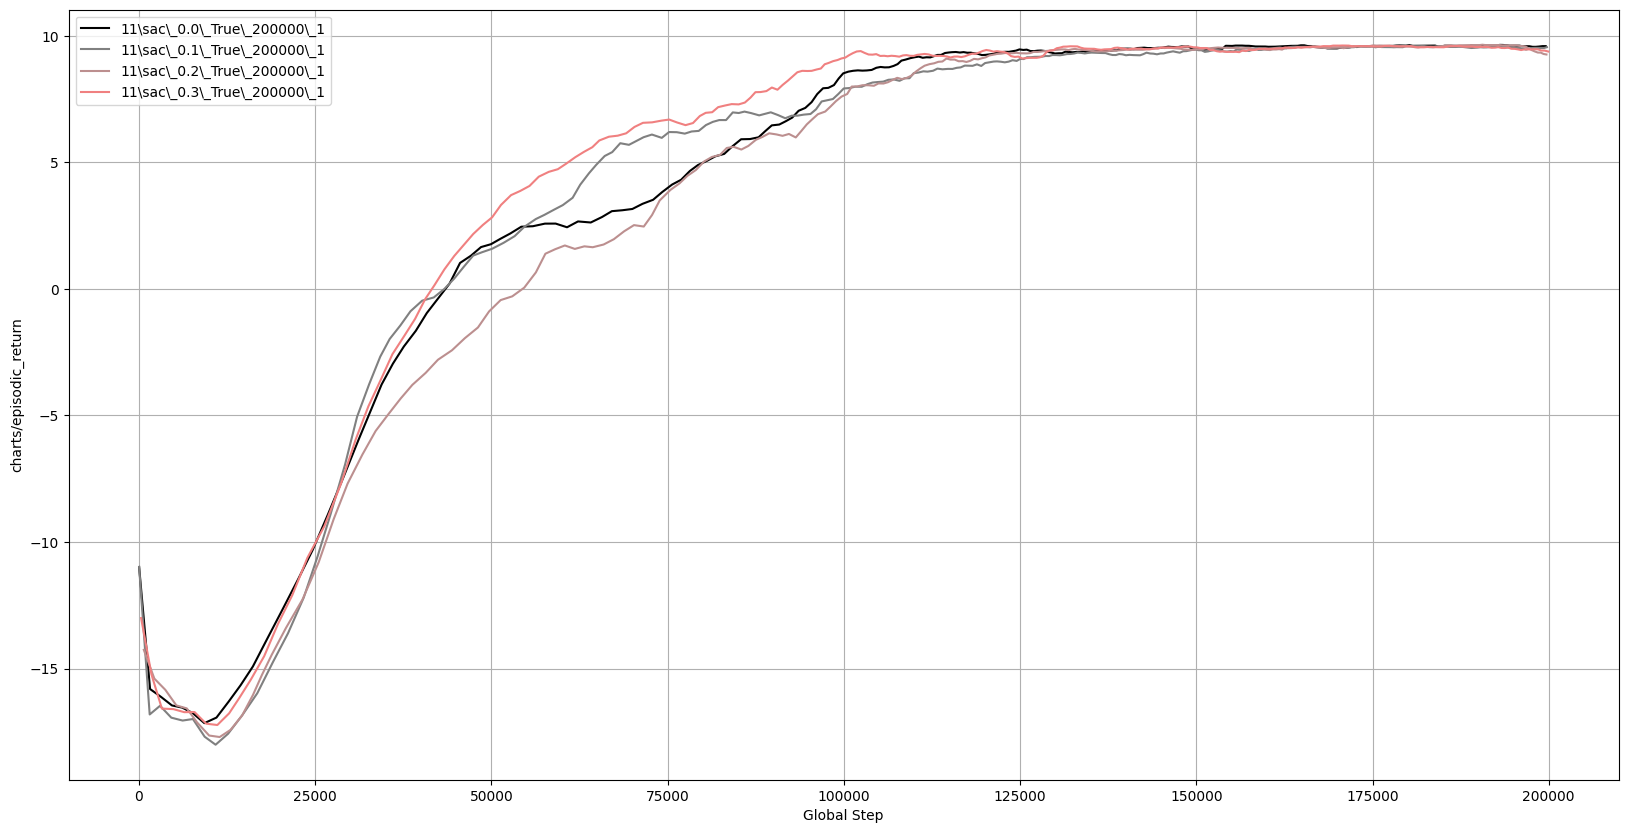

In [4]:
fig = plot_tag(df, "charts/episodic_return")

Empty DataFrame
Columns: [path, step, value]
Index: []


C:\Users\below\AppData\Local\Temp\ipykernel_23528\598594737.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


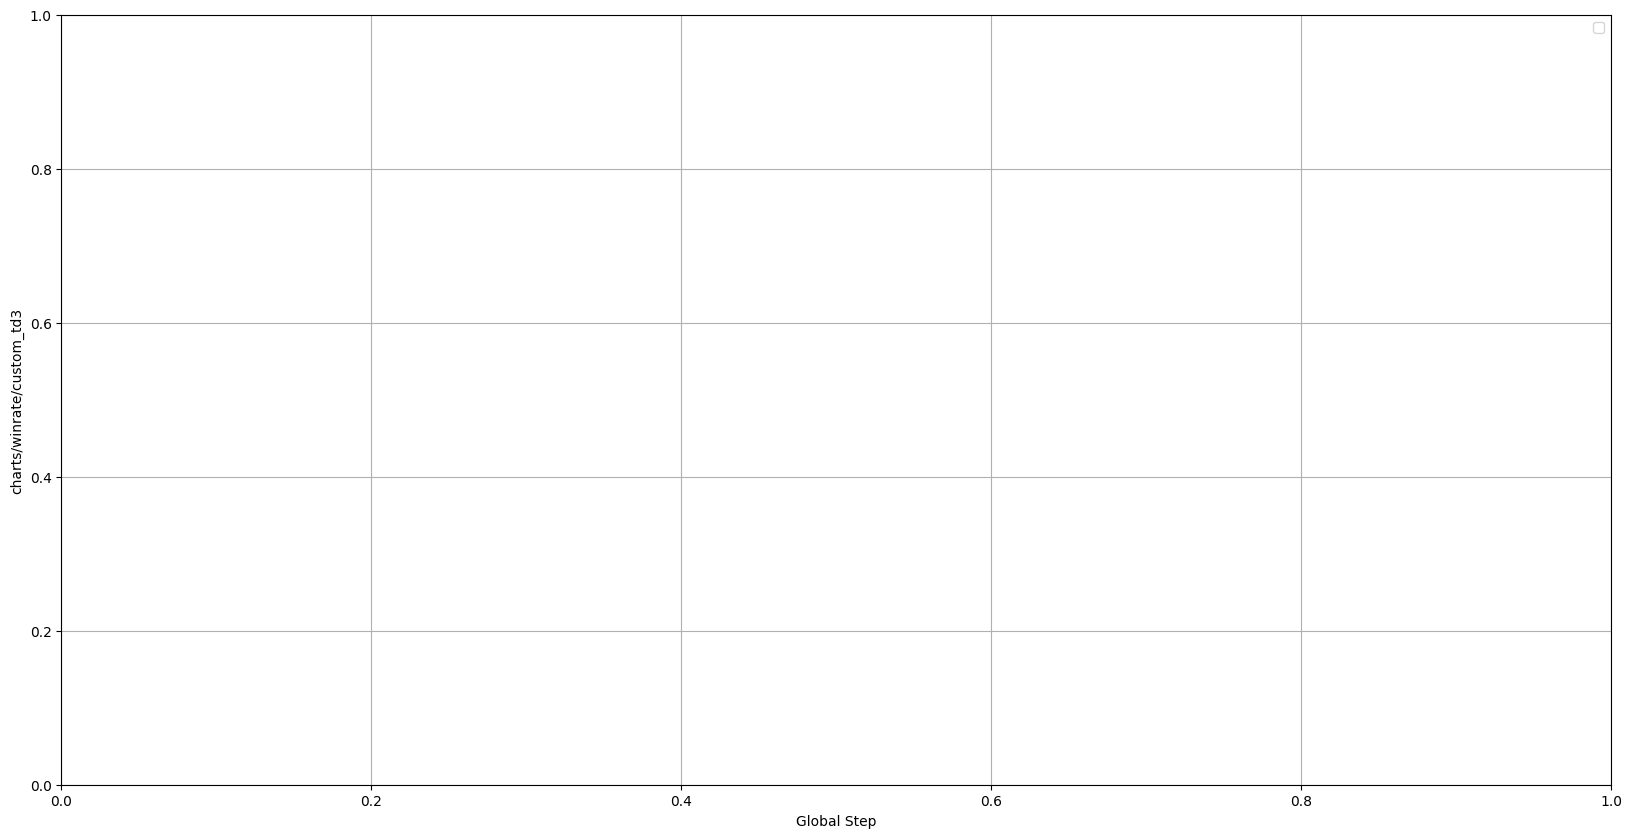

In [5]:
fig = plot_tag(df, "charts/winrate/custom_td3")

**RedQ Experiment**

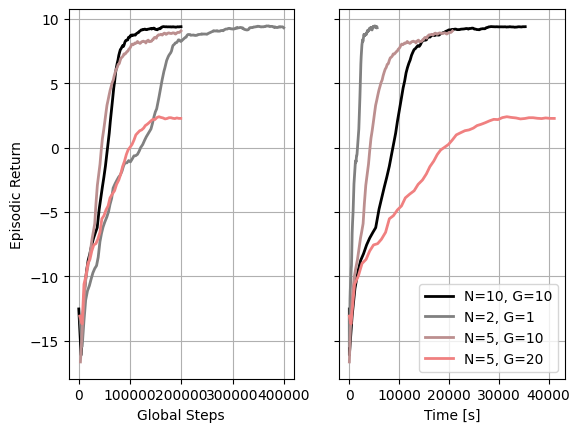

In [26]:
# Path to your event files
experiment_path = "../../runs/sac/experiment_9/*/events.*"
event_files = glob.glob(experiment_path, recursive=True)

all_data = []

for file in event_files:
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.HasField('simple_value'):  # Scalars only
                all_data.append({
                    'file': os.path.basename(file),
                    "path": file,
                    'tag': v.tag,
                    'step': e.step,
                    'value': v.simple_value
                })

df = pd.DataFrame(all_data)
dfs_res = []
x_labels = ["Global Steps", "Time [s]"]
line_labels = ["N=10, G=10", "N=2, G=1", "N=5, G=10", "N=5, G=20"]
for tag in ["charts/episodic_return", "charts/time_return"]:
    df_filtered = df[df['tag'] == tag]
    df_filtered = df_filtered[["path", "step", "value"]]
    df_filtered["path"] = df_filtered["path"].str.slice(28, 50)
    df_filtered["value_smooth"] = (
        df_filtered.groupby("path")["value"]
        .rolling(window=int(1e3), min_periods=int(1))
        .mean()
        .reset_index(level=0, drop=True)
    )
    df_filtered["group key"] = df_filtered["path"]
    df_downsampled = df_filtered.iloc[::100, :]
    dfs_res.append(df_downsampled)
fig, ax = plt.subplots(ncols=2, sharey=True)
colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
ax[0].set_ylabel("Episodic Return")
for i in range(2):
    for index, g in enumerate(dfs_res[i].groupby("group key")):
        ax[i].plot(g[1]["step"], g[1]["value_smooth"], label=line_labels[index], color=colors[index], linewidth=2)
        ax[i].set_xlabel(x_labels[i])
        ax[i].grid(True)
plt.legend()
plt.show()


In [27]:
fig.savefig("exp_time.png")
#matplot2tikz.save("exp_time.tikz", figure=fig)

**Entropy Experiment**

                       path  step      value
0  2/plot\sac_0.0_False_0.0    30 -10.744033
2  2/plot\sac_0.0_False_0.0    37 -10.708597
4  2/plot\sac_0.0_False_0.0    79 -11.403031
6  2/plot\sac_0.0_False_0.0   158 -14.479242
8  2/plot\sac_0.0_False_0.0   250  -0.494505


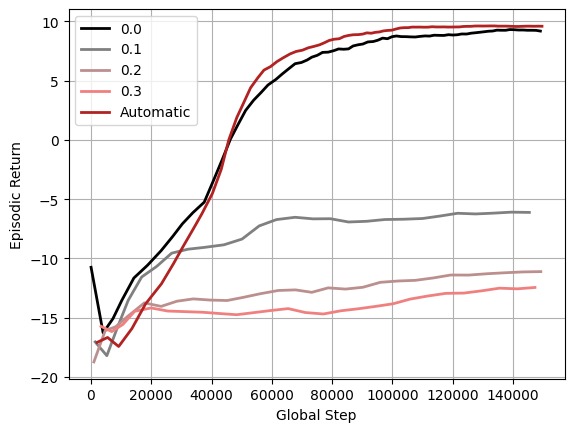

In [28]:
experiment_path = "../../runs/sac/experiment_2/plot/*/events.*"
event_files = glob.glob(experiment_path, recursive=True)
tag = "charts/episodic_return"
all_data = []

for file in event_files:
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.HasField('simple_value'):  # Scalars only
                all_data.append({
                    'file': os.path.basename(file),
                    "path": file,
                    'tag': v.tag,
                    'step': e.step,
                    'value': v.simple_value
                })
df = pd.DataFrame(all_data)
df_filtered = df[df['tag'] == tag]
df_filtered = df_filtered[["path", "step", "value"]]
df_filtered["path"] = df_filtered["path"].str.slice(26, 50)
print(df_filtered.head())
df_filtered["value_smooth"] = (
    df_filtered.groupby("path")["value"]
    .rolling(window=int(1e3), min_periods=int(1))
    .mean()
    .reset_index(level=0, drop=True)
)
df_filtered["group key"] = df_filtered["path"]
df_filtered = df_filtered[df_filtered["step"] <= 150000]
df_downsampled = df_filtered.iloc[::100, :]
line_labels = ["0.0", "0.1", "0.2", "0.3", "Automatic"]

fig, ax = plt.subplots()
colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
for index, g in enumerate(df_downsampled.groupby("group key")):
    ax.plot(g[1]["step"], g[1]["value_smooth"], label=line_labels[index], color=colors[index], linewidth=2)
ax.grid()
plt.xlabel("Global Step")
plt.ylabel("Episodic Return")
plt.legend()
plt.show()

In [29]:
#matplot2tikz.save("exp_entropy.tikz", figure=fig)
fig.savefig("exp_entropy.png")


**Colored Noise Experiment**

                       path  step      value
0  3/plot\sac_0.0_False_0.0    73 -12.537189
2  3/plot\sac_0.0_False_0.0   118 -13.255663
4  3/plot\sac_0.0_False_0.0   132   6.661013
6  3/plot\sac_0.0_False_0.0   165 -12.335249
8  3/plot\sac_0.0_False_0.0   235 -19.107708


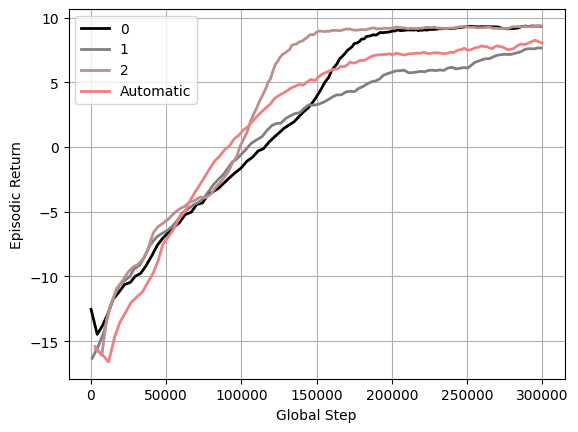

In [30]:
experiment_path = "../../runs/sac/experiment_3/plot/*/events.*"
event_files = glob.glob(experiment_path, recursive=True)
tag = "charts/episodic_return"
all_data = []

for file in event_files:
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.HasField('simple_value'):  # Scalars only
                all_data.append({
                    'file': os.path.basename(file),
                    "path": file,
                    'tag': v.tag,
                    'step': e.step,
                    'value': v.simple_value
                })
df = pd.DataFrame(all_data)
df_filtered = df[df['tag'] == tag]
df_filtered = df_filtered[["path", "step", "value"]]
df_filtered["path"] = df_filtered["path"].str.slice(26, 50)
print(df_filtered.head())
df_filtered["value_smooth"] = (
    df_filtered.groupby("path")["value"]
    .rolling(window=int(1e3), min_periods=int(1))
    .mean()
    .reset_index(level=0, drop=True)
)
df_filtered["group key"] = df_filtered["path"]
df_filtered = df_filtered[df_filtered["step"] <= 300000]
df_downsampled = df_filtered.iloc[::100, :]
line_labels = ["0", "1", "2", "Automatic"]

fig, ax = plt.subplots()
colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
for index, g in enumerate(df_downsampled.groupby("group key")):
    ax.plot(g[1]["step"], g[1]["value_smooth"], label=line_labels[index], color=colors[index], linewidth=2)
ax.grid()
plt.xlabel("Global Step")
plt.ylabel("Episodic Return")
plt.legend()
plt.show()

In [31]:
#matplot2tikz.save("exp_colored_noise.tikz", figure=fig)
fig.savefig("exp_colored_noise.png")
